In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import IPython
from keras import backend as K
random.seed(1366)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/My Drive/snli_1.0/snli_1.0_train.txt", sep="\t")
dev = pd.read_csv("/content/drive/My Drive/snli_1.0/snli_1.0_dev.txt", sep="\t")
test = pd.read_csv("/content/drive/My Drive/snli_1.0/snli_1.0_test.txt", sep="\t")

In [ ]:
train_data = train[['gold_label', 'sentence1', 'sentence2']]
dev_data = dev[['gold_label', 'sentence1', 'sentence2']]
test_data = test[['gold_label', 'sentence1', 'sentence2']]

In [ ]:
  train_data = train_data[train_data['gold_label'] != '-']
  dev_data = dev_data[dev_data['gold_label'] != '-']
  test_data = test_data[test_data['gold_label'] != '-']

In [ ]:
  train_data = train_data[train_data['sentence1'].notna()]
  train_data = train_data[train_data['sentence2'].notna()]

In [ ]:
  dev_data = dev_data[dev_data['sentence1'].notna()]
  dev_data = dev_data[dev_data['sentence2'].notna()]

In [ ]:
  test_data = test_data[test_data['sentence1'].notna()]
  test_data = test_data[test_data['sentence2'].notna()]

In [ ]:
!pip install tf-models-official

     |████████████████████████████████| 2.2 MB 4.1 MB/s 
     |████████████████████████████████| 90 kB 12.4 MB/s 
     |████████████████████████████████| 1.2 MB 59.8 MB/s 
     |████████████████████████████████| 237 kB 54.1 MB/s 
     |████████████████████████████████| 47.8 MB 61 kB/s 
     |████████████████████████████████| 4.9 MB 33.0 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 66.7 MB/s 
     |████████████████████████████████| 352 kB 71.0 MB/s 
     |████████████████████████████████| 636 kB 69.6 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 462 kB 62.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=af0c276a2890e0891b57928138c03b45b0d4f7b1f04ca418d6bbb7c8ba0cf305
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import bert
import official.nlp.bert.tokenization

In [ ]:
pretrained_bert_folder = "/content/drive/My Drive/uncased_L-12_H-768_A-12"
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(pretrained_bert_folder, "vocab.txt"),
                                                do_lower_case=True)

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def f1_score(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))

In [ ]:
def sentence_encode(sentence, tokenizer):

    tokens = list(tokenizer.tokenize(str(sentence)))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
def bert_encode(train_data, tokenizer):

    sentence_1 = tf.ragged.constant([sentence_encode(sentence, tokenizer) for sentence in np.array(train_data['sentence1'])])
    sentence_2 = tf.ragged.constant([sentence_encode(sentence, tokenizer) for sentence in np.array(train_data['sentence2'])])

    token = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence_1.shape[0]

    input_word_ids = tf.concat([token, sentence_1, sentence_2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    segment_token = tf.zeros_like(token)
    segment_s1 = tf.zeros_like(sentence_1)
    segment_s2 = tf.ones_like(sentence_2)
    input_type_ids = tf.concat([segment_token, segment_s1, segment_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    return inputs

In [ ]:
def build_model():

    max_seq_length = 125

    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

    pooled_output, _ = bert_layer([input_word_ids, input_mask, input_type_ids])

    X = tf.keras.layers.Dense(units=64, activation='relu')(pooled_output)
    X = tf.keras.layers.Dropout(0.2)(X)

    output_class = tf.keras.layers.Dense(units=3, activation='softmax')(X)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output_class)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_score, precision, recall])

    return model


In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 125)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 125)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 125)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 125, 768)]                'input_mask[0][0]',         

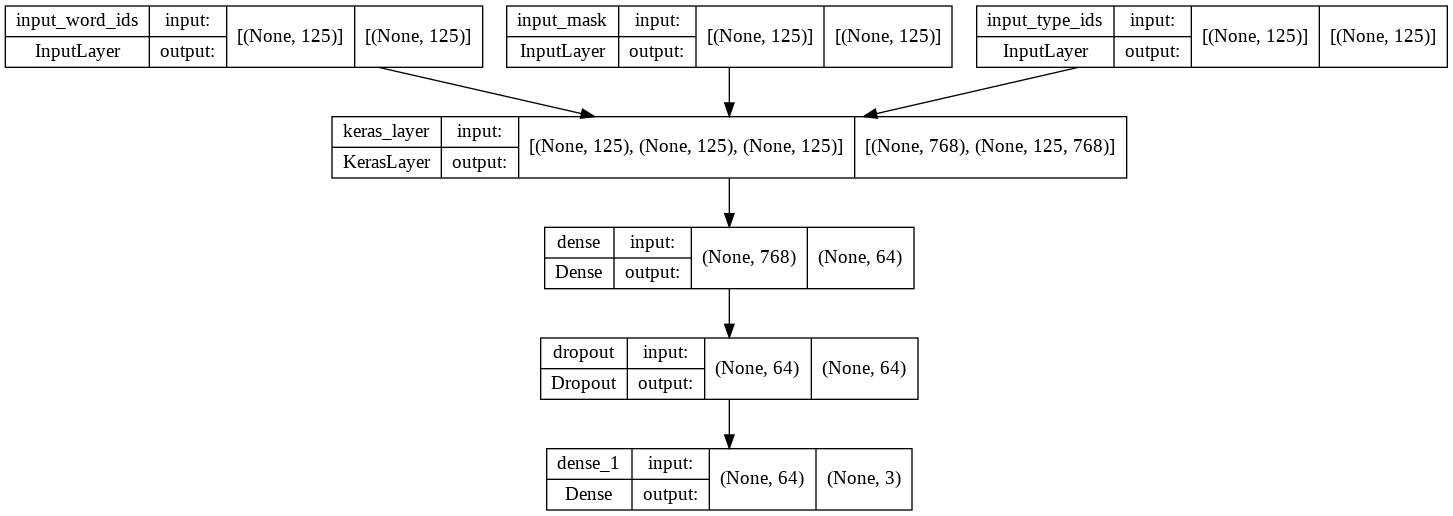

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
mask = np.random.rand(len(test_data)) < 0.5
dev_data_1 = test_data[mask]
test_data_1 = test_data[~mask]

In [ ]:
input_model = bert_encode(train_data, tokenizer)
input_dev = bert_encode(dev_data_1, tokenizer)
input_test = bert_encode(test_data_1, tokenizer)

In [ ]:
pd.options.mode.chained_assignment = None
encoder = LabelEncoder()
train_data['label_ids'] = encoder.fit_transform(train_data['gold_label'])
dev_data_1['label_ids'] = encoder.transform(dev_data_1['gold_label'])
test_data_1['label_ids'] = encoder.transform(test_data_1['gold_label'])

In [ ]:
logger = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/NLI/logs/fine-tuning_bert_1')

In [ ]:
model.fit(input_model, train_data.label_ids.values,
          epochs=2,
          batch_size=64,
          verbose=1,
          callbacks=[logger])

Epoch 1/2
8584/8584 [==============================] - 8014s 932ms/step - loss: 0.4420 - accuracy: 0.8303 - f1_score: 0.9276 - precision: 0.8109 - recall: 1.1163
Epoch 2/2
8584/8584 [==============================] - 7991s 931ms/step - loss: 0.3220 - accuracy: 0.8827 - f1_score: 0.8801 - precision: 0.7426 - recall: 1.0855


In [ ]:
(loss, accuracy, f1_score, precision, recall) = model.evaluate(input_test, test_data_1.label_ids, verbose=0)

In [ ]:
def accuracy(model, input_bert, data):

  predictions =[np.argmax(i) for i in model.predict(input_bert)]
  acc = np.mean(predictions == data.label_ids.values)
  print(acc)

In [ ]:
accuracy(model, input_dev, dev_data_1)

0.8933196300102775


In [ ]:
accuracy(model, input_test, test_data_1)

0.8987699132889696


In [ ]:
from sklearn.metrics import classification_report

prediction = model.predict(input_test, batch_size=64, verbose=1)
predictions = np.argmax(prediction, axis=1)

classification_report(test_data_1.label_ids.values, predictions)

78/78 [==============================] - 14s 179ms/step


'              precision    recall  f1-score   support\n\n           0       0.91      0.93      0.92      1648\n           1       0.90      0.92      0.91      1677\n           2       0.88      0.85      0.86      1634\n\n    accuracy                           0.90      4959\n   macro avg       0.90      0.90      0.90      4959\nweighted avg       0.90      0.90      0.90      4959\n'

In [ ]:
predicted_labels = predictions
actual_labels = test_data_1.label_ids.values

In [ ]:
predicted_labels

array([0, 0, 0, ..., 0, 1, 2])

In [ ]:
actual_labels

array([2, 0, 0, ..., 0, 1, 2])

In [ ]:
# Bad examples
counter = 0
for i in range(len(actual_labels)):
  if actual_labels[i] != predicted_labels[i]:
      print("Index: ", i, "Actual: ", actual_labels[i], "Predicted: ",predicted_labels[i])
      counter = counter + 1
print(counter)
print("Sentence 1: ", test_data_1['sentence1'].iloc[0], "\nSentence 2: ", test_data_1['sentence2'].iloc[0])
print("Sentence 1: ", test_data_1['sentence1'].iloc[4], "\nSentence 2: ", test_data_1['sentence2'].iloc[4])
print("Sentence 1: ", test_data_1['sentence1'].iloc[9], "\nSentence 2: ", test_data_1['sentence2'].iloc[9])

Index:  0 Actual:  2 Predicted:  0
Index:  4 Actual:  0 Predicted:  1
Index:  9 Actual:  2 Predicted:  0
Index:  25 Actual:  2 Predicted:  0
Index:  33 Actual:  2 Predicted:  1
Index:  34 Actual:  2 Predicted:  0
Index:  40 Actual:  0 Predicted:  1
Index:  42 Actual:  2 Predicted:  0
Index:  48 Actual:  2 Predicted:  0
Index:  72 Actual:  2 Predicted:  1
Index:  80 Actual:  1 Predicted:  0
Index:  96 Actual:  1 Predicted:  0
Index:  100 Actual:  2 Predicted:  1
Index:  114 Actual:  2 Predicted:  1
Index:  134 Actual:  2 Predicted:  0
Index:  147 Actual:  1 Predicted:  2
Index:  150 Actual:  1 Predicted:  0
Index:  183 Actual:  0 Predicted:  1
Index:  187 Actual:  1 Predicted:  2
Index:  188 Actual:  0 Predicted:  2
Index:  196 Actual:  2 Predicted:  0
Index:  201 Actual:  2 Predicted:  1
Index:  205 Actual:  1 Predicted:  2
Index:  215 Actual:  0 Predicted:  2
Index:  224 Actual:  0 Predicted:  2
Index:  238 Actual:  2 Predicted:  0
Index:  242 Actual:  2 Predicted:  1
Index:  244 Actu

In [ ]:
# Good examples
counter = 0
for i in range(len(actual_labels)):
  if actual_labels[i] == predicted_labels[i]:
      print("Index: ", i, "Actual: ", actual_labels[i], "Predicted: ",predicted_labels[i])
      counter = counter + 1
print(counter)
print("Sentence 1: ", test_data_1['sentence1'].iloc[1], "\nSentence 2: ", test_data_1['sentence2'].iloc[1])
print("Sentence 1: ", test_data_1['sentence1'].iloc[2], "\nSentence 2: ", test_data_1['sentence2'].iloc[2])
print("Sentence 1: ", test_data_1['sentence1'].iloc[3], "\nSentence 2: ", test_data_1['sentence2'].iloc[3])

Index:  1 Actual:  0 Predicted:  0
Index:  2 Actual:  0 Predicted:  0
Index:  3 Actual:  2 Predicted:  2
Index:  5 Actual:  0 Predicted:  0
Index:  6 Actual:  1 Predicted:  1
Index:  7 Actual:  1 Predicted:  1
Index:  8 Actual:  1 Predicted:  1
Index:  10 Actual:  1 Predicted:  1
Index:  11 Actual:  2 Predicted:  2
Index:  12 Actual:  0 Predicted:  0
Index:  13 Actual:  1 Predicted:  1
Index:  14 Actual:  1 Predicted:  1
Index:  15 Actual:  0 Predicted:  0
Index:  16 Actual:  2 Predicted:  2
Index:  17 Actual:  0 Predicted:  0
Index:  18 Actual:  1 Predicted:  1
Index:  19 Actual:  2 Predicted:  2
Index:  20 Actual:  0 Predicted:  0
Index:  21 Actual:  0 Predicted:  0
Index:  22 Actual:  2 Predicted:  2
Index:  23 Actual:  2 Predicted:  2
Index:  24 Actual:  2 Predicted:  2
Index:  26 Actual:  0 Predicted:  0
Index:  27 Actual:  1 Predicted:  1
Index:  28 Actual:  0 Predicted:  0
Index:  29 Actual:  1 Predicted:  1
Index:  30 Actual:  2 Predicted:  2
Index:  31 Actual:  1 Predicted:  1